In [3]:
import os, shutil

base_dirs = [
    r"D:\databackup\bdddddddddd\train",
    r"D:\databackup\bdddddddddd\val",
    r"D:\databackup\bdddddddddd\test"
]

output_images = r"D:\pro1\merged\images"
output_labels = r"D:\pro1\merged\labels"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

counter = 0
for split_dir in base_dirs:
    images_dir = os.path.join(split_dir, "images")
    labels_dir = os.path.join(split_dir, "labels")
    
    for img_name in os.listdir(images_dir):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        
        label_name = os.path.splitext(img_name)[0] + ".json"
        img_path = os.path.join(images_dir, img_name)
        label_path = os.path.join(labels_dir, label_name)

        if os.path.exists(label_path):  # Only move if label exists
            new_img = os.path.join(output_images, f"{counter:06d}.jpg")
            new_lbl = os.path.join(output_labels, f"{counter:06d}.json")
            shutil.copy2(img_path, new_img)
            shutil.copy2(label_path, new_lbl)
            counter += 1

print("✅ Done merging! Total files:", counter)


✅ Done merging! Total files: 99784


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_path = r"E:\mixed\bus-tuktuk.v1-ragab.yolov8"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

train_images_path = os.path.join(base_path, "train", "images")
train_labels_path = os.path.join(base_path, "train", "labels")

val_images_path = os.path.join(base_path, "val", "images")
val_labels_path = os.path.join(base_path, "val", "labels")

# Create folders
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

# Get all images
images = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Split train/val
train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)

def move_files(files, split_type):
    total = len(files)
    for i, img in enumerate(files):
        img_src = os.path.join(images_path, img)
        txt_src = os.path.join(labels_path, img.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        if split_type == 'train':
            img_dst = os.path.join(train_images_path, img)
            txt_dst = os.path.join(train_labels_path, os.path.basename(txt_src))
        else:
            img_dst = os.path.join(val_images_path, img)
            txt_dst = os.path.join(val_labels_path, os.path.basename(txt_src))

        shutil.copy(img_src, img_dst)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)

        # progress bar
        progress = (i + 1) / total * 100
        print(f"{split_type.upper()} Progress: {progress:.2f}% ({i+1}/{total})", end='\r')

move_files(train_files, 'train')
move_files(val_files, 'val')

print("Split completed successfully!")


TRAIN Progress: 100.00% (1889/1889)
VAL Progress: 100.00% (473/473)
Split completed successfully!


In [ ]:
import json
from tqdm import tqdm
from PIL import Image
output_jsons=r"D:\pro1\merged\labels"
input_json_dir = output_jsons
input_img_dir = output_images
output_yolo_dir = r"D:\pro1\merged\labels_yolo"
os.makedirs(output_yolo_dir, exist_ok=True)

class_map = {}
next_id = 0

def get_class_id(category):
    global next_id
    if category not in class_map:
        class_map[category] = next_id
        next_id += 1
    return class_map[category]

for file in tqdm(os.listdir(input_json_dir)):
    if not file.endswith(".json"):
        continue

    json_path = os.path.join(input_json_dir, file)
    img_path = os.path.join(input_img_dir, file.replace(".json", ".jpg"))

    if not os.path.exists(img_path):
        continue

    with open(json_path, "r") as f:
        data = json.load(f)

    try:
        with Image.open(img_path) as im:
            img_w, img_h = im.size
    except:
        continue

    objects = []
    if "frames" in data and data["frames"]:
        for obj in data["frames"][0].get("objects", []):
            if "box2d" not in obj:
                continue
            cat = obj["category"]
            box = obj["box2d"]

            x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

            # Normalize
            x_center = ((x1 + x2) / 2) / img_w
            y_center = ((y1 + y2) / 2) / img_h
            w = (x2 - x1) / img_w
            h = (y2 - y1) / img_h

            cls_id = get_class_id(cat)
            objects.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    if objects:
        out_path = os.path.join(output_yolo_dir, file.replace(".json", ".txt"))
        with open(out_path, "w") as f:
            f.write("\n".join(objects))

print("✅ Conversion complete!")
print("📋 Total classes:", len(class_map))
print("\nClass mapping:")
for k, v in class_map.items():
    print(f"  {v}: {k}")


100%|██████████| 99784/99784 [02:41<00:00, 617.28it/s]

✅ Conversion complete!
📋 Total classes: 10

Class mapping:
  0: traffic light
  1: traffic sign
  2: car
  3: person
  4: bus
  5: truck
  6: rider
  7: bike
  8: motor
  9: train


## distrebution

In [ ]:
import numpy as np
from collections import Counter

labels_dir = output_yolo_dir

class_counts = Counter()
images_with_classes = []
bbox_sizes = []

for label_file in os.listdir(labels_dir):
    path = os.path.join(labels_dir, label_file)
    with open(path, "r") as f:
        lines = f.readlines()
    if not lines:
        continue
    
    classes = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        cls, x, y, w, h = parts
        cls = int(cls)
        w, h = float(w), float(h)
        classes.append(cls)
        bbox_sizes.append(w * h)
        class_counts[cls] += 1
    
    images_with_classes.append(set(classes))

single_class_images = sum(1 for s in images_with_classes if len(s) == 1)

print(f"📦 Total images: {len(images_with_classes)}")
print(f"🧩 Single-class images: {single_class_images}")
print(f"\n📊 Class distribution:")
for c, count in class_counts.most_common():
    print(f"   Class {c}: {count}")

print(f"\n📏 Avg bbox size (all classes): {np.mean(bbox_sizes):.5f}")
print(f"📉 Std bbox size: {np.std(bbox_sizes):.5f}")


📦 Total images: 99784
🧩 Single-class images: 6443

📊 Class distribution:
   Class 2: 1020630
   Class 1: 343698
   Class 0: 265935
   Class 3: 129268
   Class 5: 42914
   Class 4: 16474
   Class 7: 10231
   Class 6: 6461
   Class 8: 4285
   Class 9: 179

📏 Avg bbox size (all classes): 0.00732
📉 Std bbox size: 0.02467


In [ ]:
import os
import json
from collections import Counter
from tqdm import tqdm

json_dir = r"D:\pro1\merged\labels"

class_counts = Counter()

for file in tqdm(os.listdir(json_dir)):
    if not file.endswith(".json"):
        continue

    path = os.path.join(json_dir, file)
    with open(path, "r") as f:
        data = json.load(f)

    for frame in data.get("frames", []):
        for obj in frame.get("objects", []):
            cat = obj.get("category")
            if cat:
                class_counts[cat] += 1

print("\n📊 Class Distribution (raw JSON labels):\n")
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls:<25} {count}")


100%|██████████| 99784/99784 [00:44<00:00, 2247.87it/s]


📊 Class Distribution (raw JSON labels):

car                       1020630
lane/single white         352922
traffic sign              343698
traffic light             265935
lane/road curb            157079
lane/crosswalk            154181
person                    129268
area/drivable             91438
area/alternative          88254
lane/double yellow        53437
truck                     42914
lane/single yellow        28888
bus                       16474
bike                      10231
lane/double white         8037
rider                     6461
motor                     4285
lane/single other         390
train                     179
lane/double other         37
area/unknown              2


In [8]:
import os

labels_dir = r"D:\pro1\merged\labels_yolo"
images_dir = r"D:\pro1\merged\images"

car_cls_id = 2

total_images = 0
images_has_only_cars = 0
total_car_boxes_in_only_car_images = 0

only_car_files = []

for lbl_file in os.listdir(labels_dir):
  if lbl_file.endswith(".txt"):
    with open(os.path.join(labels_dir, lbl_file), 'r') as f:
      lines = [line.strip() for line in f.readlines() if line.strip()]

      if not lines:
        continue

      total_images += 1
      cls_ids = [int(line.split()[0]) for line in lines]
      num_bounding_box = [cls for cls in cls_ids if cls == car_cls_id]

      if all(cls == car_cls_id for cls in cls_ids):
        images_has_only_cars += 1
        total_car_boxes_in_only_car_images += len(cls_ids)
        only_car_files.append(lbl_file)

print(f"num of total images {total_images}")
print(f"num of images has only cars {images_has_only_cars}")
print(f"Total bounding boxes for 'only car' images: {total_car_boxes_in_only_car_images}")
print(f"percentege of images has only cars {(images_has_only_cars / total_images) * 100:.2f}%")

num of total images 99784
num of images has only cars 6060
Total bounding boxes for 'only car' images: 64606
percentege of images has only cars 6.07%


## size analysis

In [ ]:
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
from PIL import Image

images_dir = output_images
labels_dir = output_yolo_dir

class_box_areas = defaultdict(list)
class_counts = Counter()
small_boxes = Counter()

SMALL_BOX_THRESHOLD = 0.002

label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
print(f"🔍 Analyzing {len(label_files)} label files...")

for label_file in tqdm(label_files):
    img_file = os.path.splitext(label_file)[0] + ".jpg"
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(img_path):
        continue

    try:
        with Image.open(img_path) as im:
            width, height = im.size
    except:
        continue

    img_area = width * height

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        cls, x, y, w, h = parts
        cls = int(cls)
        w, h = float(w), float(h)

        box_area_rel = w * h  
        box_area_pixels = box_area_rel * img_area

        class_box_areas[cls].append(box_area_rel)
        class_counts[cls] += 1

        if box_area_rel < SMALL_BOX_THRESHOLD:
            small_boxes[cls] += 1


🔍 Analyzing 99784 label files...


100%|██████████| 99784/99784 [01:29<00:00, 1111.66it/s]


## report

In [10]:
print("\n📊 === CLASS ANALYSIS REPORT ===\n")

total_boxes = sum(class_counts.values())
total_small_boxes = sum(small_boxes.values())
after_clean_boxes = total_boxes - total_small_boxes

for cls in sorted(class_counts.keys()):
    areas = np.array(class_box_areas[cls])
    avg_area = np.mean(areas)
    std_area = np.std(areas)
    min_area = np.min(areas)
    max_area = np.max(areas)
    small_ratio = (small_boxes[cls] / class_counts[cls]) * 100

    print(f"🧩 Class {cls}:")
    print(f"   - Total objects: {class_counts[cls]}")
    print(f"   - Avg box area: {avg_area:.5f}")
    print(f"   - Std dev: {std_area:.5f}")
    print(f"   - Min area: {min_area:.5f}")
    print(f"   - Max area: {max_area:.5f}")
    print(f"   - Small boxes (<{SMALL_BOX_THRESHOLD}): {small_boxes[cls]} ({small_ratio:.2f}%)\n")

print("📦 TOTAL OBJECTS BEFORE CLEAN:", total_boxes)
print("🧹 TOTAL OBJECTS AFTER CLEAN:", after_clean_boxes)
print(f"⚠️ Small boxes removed: {total_small_boxes} ({(total_small_boxes/total_boxes)*100:.2f}%)")



📊 === CLASS ANALYSIS REPORT ===

🧩 Class 0:
   - Total objects: 265935
   - Avg box area: 0.00055
   - Std dev: 0.00177
   - Min area: 0.00000
   - Max area: 0.38057
   - Small boxes (<0.002): 255529 (96.09%)

🧩 Class 1:
   - Total objects: 343698
   - Avg box area: 0.00130
   - Std dev: 0.00435
   - Min area: 0.00000
   - Max area: 0.99578
   - Small boxes (<0.002): 296451 (86.25%)

🧩 Class 2:
   - Total objects: 1020630
   - Avg box area: 0.01019
   - Std dev: 0.02707
   - Min area: 0.00000
   - Max area: 0.66476
   - Small boxes (<0.002): 570840 (55.93%)

🧩 Class 3:
   - Total objects: 129268
   - Avg box area: 0.00317
   - Std dev: 0.00810
   - Min area: 0.00000
   - Max area: 0.37428
   - Small boxes (<0.002): 86062 (66.58%)

🧩 Class 4:
   - Total objects: 16474
   - Avg box area: 0.03810
   - Std dev: 0.07862
   - Min area: 0.00000
   - Max area: 0.84174
   - Small boxes (<0.002): 4334 (26.31%)

🧩 Class 5:
   - Total objects: 42914
   - Avg box area: 0.03006
   - Std dev: 0.0639

## handling and clean noise boxes , small , empty , large number of cars 

In [ ]:
import os
import shutil

src_img_dir = r"D:\pro1\merged\images"
src_lbl_dir = r"D:\pro1\merged\labels_yolo"

dst_img_dir = r"D:\pro2\cleaned\images"
dst_lbl_dir = r"D:\pro2\cleaned\labels"

os.makedirs(dst_img_dir, exist_ok=True)
os.makedirs(dst_lbl_dir, exist_ok=True)

IMG_W, IMG_H = 1280, 720
AREA_THRESH = 0.002

total_boxes = 0
removed_boxes = 0
images_kept = 0
images_removed = 0

for file in os.listdir(src_lbl_dir):
    if not file.endswith(".txt"):
        continue

    label_path = os.path.join(src_lbl_dir, file)
    with open(label_path, "r") as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        cls, xc, yc, w, h = map(float, parts)
        area = w * h
        total_boxes += 1
        if area >= AREA_THRESH:
            new_lines.append(line)
        else:
            removed_boxes += 1

    if len(new_lines) > 0:
        new_label_path = os.path.join(dst_lbl_dir, file)
        with open(new_label_path, "w") as f:
            f.writelines(new_lines)

        img_name = os.path.splitext(file)[0] + ".jpg"
        src_img_path = os.path.join(src_img_dir, img_name)
        dst_img_path = os.path.join(dst_img_dir, img_name)

        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)
            images_kept += 1
    else:
        images_removed += 1

print("\n🧹 === CLEANING SUMMARY ===")
print(f"Total boxes processed: {total_boxes}")
print(f"Removed small boxes: {removed_boxes} ({(removed_boxes/total_boxes)*100:.2f}%)")
print(f"Images kept: {images_kept}")
print(f"Images removed: {images_removed}")
print("\n✅ Cleaned dataset saved in: D:\\pro1\\cleaned")



🧹 === CLEANING SUMMARY ===
Total boxes processed: 1840075
Removed small boxes: 1234495 (67.09%)
Images kept: 97038
Images removed: 2746

✅ Cleaned dataset saved in: D:\pro1\cleaned


In [ ]:
import numpy as np
from collections import Counter

labels_dir = r"D:\pro2\cleaned\labels"

class_counts = Counter()
images_with_classes = []
bbox_sizes = []

for label_file in os.listdir(labels_dir):
    path = os.path.join(labels_dir, label_file)
    with open(path, "r") as f:
        lines = f.readlines()
    if not lines:
        continue
    
    classes = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        cls, x, y, w, h = parts
        cls = int(cls)
        w, h = float(w), float(h)
        classes.append(cls)
        bbox_sizes.append(w * h)
        class_counts[cls] += 1
    
    images_with_classes.append(set(classes))

single_class_images = sum(1 for s in images_with_classes if len(s) == 1)

print(f"📦 Total images: {len(images_with_classes)}")
print(f"🧩 Single-class images: {single_class_images}")
print(f"\n📊 Class distribution:")
for c, count in class_counts.most_common():
    print(f"   Class {c}: {count}")

print(f"\n📏 Avg bbox size (all classes): {np.mean(bbox_sizes):.5f}")
print(f"📉 Std bbox size: {np.std(bbox_sizes):.5f}")


📦 Total images: 97038
🧩 Single-class images: 38509

📊 Class distribution:
   Class 2: 449790
   Class 1: 47247
   Class 3: 43206
   Class 5: 31077
   Class 4: 12140
   Class 0: 10406
   Class 7: 5992
   Class 6: 3148
   Class 8: 2458
   Class 9: 116

📏 Avg bbox size (all classes): 0.02097
📉 Std bbox size: 0.03963


## merging the sup+main
### sup data : the data we created manualy on roboflow 
### main data : BDD100K after cleaning 
### we have enough number of cars so we need to focus on the weak classes to be merged 

In [ ]:
import os
import shutil

main_imgs = r"D:\pro2\cleaned\images"
main_lbls = r"D:\pro2\cleaned\labels"

support_imgs = r"D:\cleaned.v1-original_index.yolov8\support_cleaned\images"
support_lbls = r"D:\cleaned.v1-original_index.yolov8\support_cleaned\labels"

merged_imgs = r"D:\pro2\merged_final\images"
merged_lbls = r"D:\pro2\merged_final\labels"

os.makedirs(merged_imgs, exist_ok=True)
os.makedirs(merged_lbls, exist_ok=True)

def has_only_car(label_path):
    if not os.path.exists(label_path):
        return False
    with open(label_path, "r") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    if not lines:
        return False
    classes = [int(line.split()[0]) for line in lines]
    return all(c == 2 for c in classes)  


removed_count = 0
kept_count = 0

for lbl_file in os.listdir(main_lbls):
    if not lbl_file.endswith(".txt"):
        continue
    lbl_path = os.path.join(main_lbls, lbl_file)
    img_name = os.path.splitext(lbl_file)[0] + ".jpg"
    img_path = os.path.join(main_imgs, img_name)

    if has_only_car(lbl_path):
        removed_count += 1
        continue

    shutil.copy(lbl_path, os.path.join(merged_lbls, lbl_file))
    if os.path.exists(img_path):
        shutil.copy(img_path, os.path.join(merged_imgs, img_name))
        kept_count += 1

for lbl_file in os.listdir(support_lbls):
    if not lbl_file.endswith(".txt"):
        continue
    src_lbl = os.path.join(support_lbls, lbl_file)
    src_img = os.path.join(support_imgs, os.path.splitext(lbl_file)[0] + ".jpg")

    shutil.copy(src_lbl, os.path.join(merged_lbls, lbl_file))
    if os.path.exists(src_img):
        shutil.copy(src_img, os.path.join(merged_imgs, os.path.basename(src_img)))

print("✅ Unified version created successfully!")
print(f"✅ Copied images from the original: {kept_count}")
print(f"🚫 Excluded images (car only): {removed_count}")
print(f"➕ Added support images from: {support_imgs}")
print(f"📦 Final output path: {merged_imgs}")

✅ Unified version created successfully!
✅ Copied images from original: 61104
🚫 Excluded images (car only): 35934
➕ Added support images from: D:\cleaned.v1-original_index.yolov8\support_cleaned\images
📦 Final output path: D:\pro2\merged_final\images


## after mixing sup+main 

{'0traffic light (ID=0)': 10406, '1traffic sign (ID=1)': 47247, '2car (ID=2)': 449790, '3person (ID=3)': 43206, '5truck (ID=5)': 31077, '4bus (ID=4)': 12140, '6rider (ID=6)': 3148, '7bike (ID=7)': 5992, '8motor (ID=8)': 2458, '9train (ID=9)': 116}


C:\Users\mo_13\AppData\Local\Temp\ipykernel_11808\1375461181.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


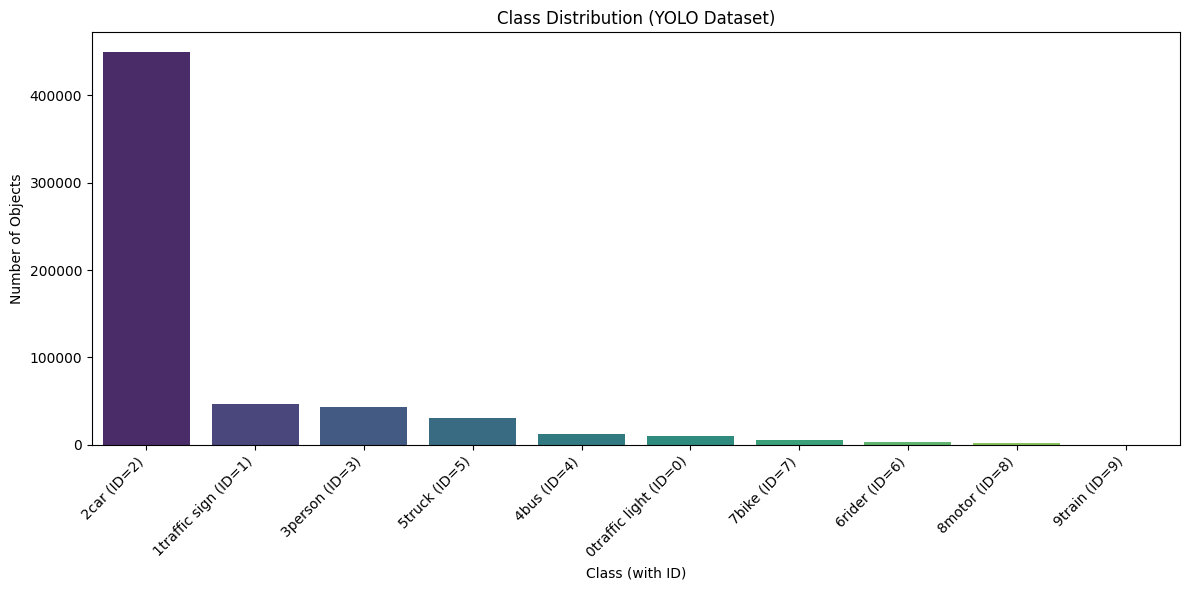

In [ ]:
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

labels_folder = r"D:\pro2\cleaned\labels"

yaml_path = r"D:\cleaned.v1-original_index.yolov8\data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

if isinstance(data["names"], dict):
    class_names = data["names"]
else:
    class_names = {i: name for i, name in enumerate(data["names"])}

class_counts = Counter()

for label_file in os.listdir(labels_folder):
    if label_file.endswith(".txt"):
        with open(os.path.join(labels_folder, label_file), "r") as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

class_counts_named = {f"{class_names[cid]} (ID={cid})": count for cid, count in class_counts.items()}

print(class_counts_named)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=list(class_counts_named.keys()),
    y=list(class_counts_named.values()),
    palette="viridis",
    order=sorted(class_counts_named, key=class_counts_named.get, reverse=True)
)
plt.title("Class Distribution (YOLO Dataset)")
plt.xlabel("Class (with ID)")
plt.ylabel("Number of Objects")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#

In [14]:
import os

labels_dir = r"D:\pro2\cleaned\labels"
images_dir = r"D:\pro2\cleaned\images"

car_cls_id = 2

total_images = 0
images_with_no_car = 0
total_car_boxes_in_only_car_images = 0

no_car_images = []

for lbl_file in os.listdir(labels_dir):
  if lbl_file.endswith(".txt"):
    with open(os.path.join(labels_dir, lbl_file), 'r') as f:
      lines = [line.strip() for line in f.readlines() if line.strip()]

      if not lines:
        continue

      total_images += 1
      cls_ids = [int(line.split()[0]) for line in lines]
      num_bounding_box = [cls for cls in cls_ids if cls == car_cls_id]

      if car_cls_id not in cls_ids:
        images_with_no_car += 1
        # total_car_boxes_in_only_car_images += len(cls_ids)
        no_car_images.append(lbl_file)

print(f"num of total images {total_images}")
print(f"num of images with no cars {images_with_no_car}")
print(f"percentege of images with no cars {(images_with_no_car / total_images) * 100:.2f}%")

num of total images 97038
num of images with no cars 3699
percentege of images with no cars 3.81%


In [6]:
import os

images = set(os.path.splitext(f)[0] for f in os.listdir(r"D:\pro2\merged_final\images"))
labels = set(os.path.splitext(f)[0] for f in os.listdir(r"D:\pro2\merged_final\labels"))

missing_labels = images - labels
missing_images = labels - images

print(f"🖼️ Images without labels: {len(missing_labels)}")
print(f"🏷️ Labels without images: {len(missing_images)}")


🖼️ Images without labels: 0
🏷️ Labels without images: 0


## train test val 

In [ ]:
import os
import random
import shutil
from tqdm import tqdm

images_dir = r"D:\merged_final\images"
labels_dir = r"D:\merged_final\labels"
output_root = r"D:\final_split_v2"

split_ratio = {"train": 0.8, "val": 0.1, "test": 0.1}

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "labels"), exist_ok=True)

all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(all_images)
n = len(all_images)

n_train = int(split_ratio["train"] * n)
n_val = int(split_ratio["val"] * n)
n_test = n - n_train - n_val

splits = {
    "train": all_images[:n_train],
    "val": all_images[n_train:n_train + n_val],
    "test": all_images[n_train + n_val:]
}

for split, files in splits.items():
    print(f"\n📦 Processing {split} ({len(files)} images)...")
    for img_file in tqdm(files):
        base_name, _ = os.path.splitext(img_file)
        src_img = os.path.join(images_dir, img_file)
        src_lbl = os.path.join(labels_dir, f"{base_name}.txt")

        dst_img = os.path.join(output_root, split, "images", img_file)
        dst_lbl = os.path.join(output_root, split, "labels", f"{base_name}.txt")

        shutil.copy2(src_img, dst_img)

        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, dst_lbl)

print("\n✅ Split complete!")
print(f"Total images: {n}")
print(f"train: {len(splits['train'])} ({len(splits['train'])/n*100:.2f}%)")
print(f"val: {len(splits['val'])} ({len(splits['val'])/n*100:.2f}%)")
print(f"test: {len(splits['test'])} ({len(splits['test'])/n*100:.2f}%)")
print(f"Output saved at: {output_root}")



📦 Processing train (77414 images)...


100%|██████████| 77414/77414 [04:54<00:00, 262.67it/s]



📦 Processing val (9676 images)...


100%|██████████| 9676/9676 [00:37<00:00, 255.13it/s]



📦 Processing test (9678 images)...


100%|██████████| 9678/9678 [00:37<00:00, 259.01it/s]


✅ Split complete!
Total images: 96768
train: 77414 (80.00%)
val: 9676 (10.00%)
test: 9678 (10.00%)
Output saved at: D:\final_split_v2


## tuning data (data we used to tune the model and solve testing issues)

{'9train (ID=9)': 8954, '0traffic light (ID=0)': 15014, '1traffic sign (ID=1)': 27151, '2car (ID=2)': 153825, '4bus (ID=4)': 13082, '5truck (ID=5)': 17066, '3person (ID=3)': 38517, '6rider (ID=6)': 13235, '7bike (ID=7)': 6943, '8motor (ID=8)': 16054, 'tuktuk (ID=11)': 3657, 'banner (ID=10)': 36123}


C:\Users\mo_13\AppData\Local\Temp\ipykernel_11808\1564671573.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


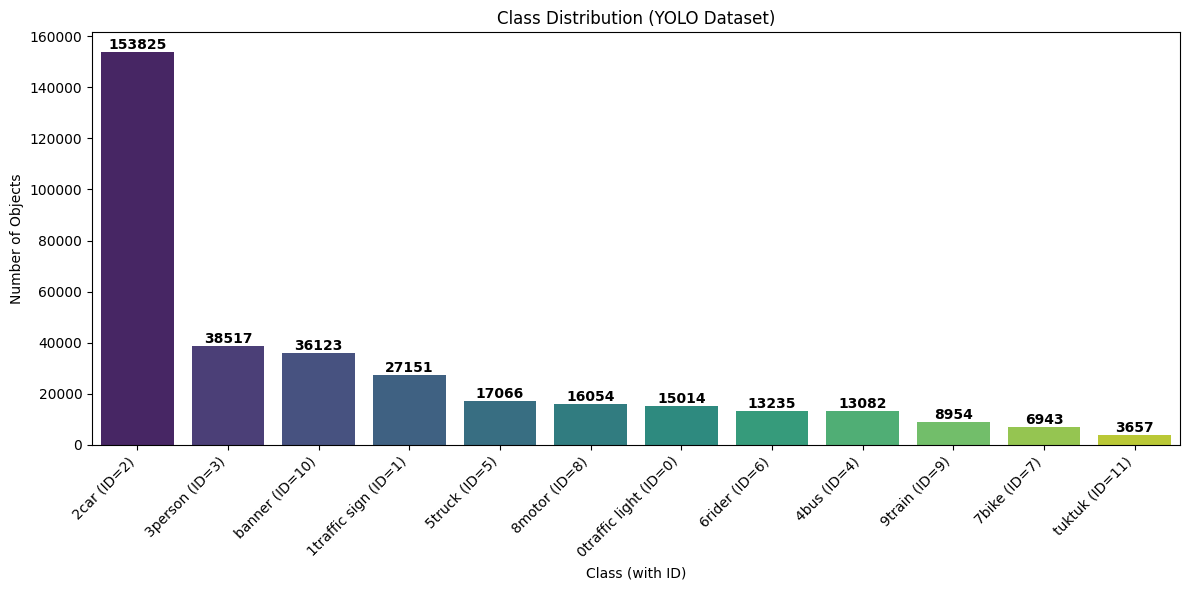

In [ ]:
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

labels_folder = r"E:\mixed\labels"

yaml_path = r"D:\cleaned.v1-original_index.yolov8\data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

if isinstance(data["names"], dict):
    class_names = data["names"]
else:
    class_names = {i: name for i, name in enumerate(data["names"])}

class_counts = Counter()

for label_file in os.listdir(labels_folder):
    if label_file.endswith(".txt"):
        with open(os.path.join(labels_folder, label_file), "r") as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

class_counts_named = {f"{class_names[cid]} (ID={cid})": count for cid, count in class_counts.items()}

print(class_counts_named)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=list(class_counts_named.keys()),
    y=list(class_counts_named.values()),
    palette="viridis",
    order=sorted(class_counts_named, key=class_counts_named.get, reverse=True)
)


for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,     
        p.get_height(),                    
        int(p.get_height()),               
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.title("Class Distribution (YOLO Dataset)")
plt.xlabel("Class (with ID)")
plt.ylabel("Number of Objects")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()